# Анализ временных рядов - практика

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [ ]:
#!python -m pip install prophet

## Данные

В этой практике работаем с пятилетней историей посещения портала [statforecasting.com](https://regressit.com/statforecasting.com/). 

Описание данных:
- **day** - день недели
- **day_of_week** - номер дня недели
- **date** - дата в формате год-месяц-день
- **page_loads** - количество загрузок страницы
- **unique_visits** - количество уникальных посетителей
- **first_time_visits** - количество новых посетителей
- **returning_visits** - количество неновых посетителей

Данные прошли небольшую предобработку и немного отличаются от [оригинала](https://www.kaggle.com/datasets/bobnau/daily-website-visitors):
- внесены косметические правки в названиях колонок и в стиль написания чисел
- проверили, что нет пропусков в временном ряду

Мысли по этим данным:
- Данные подвержены сложной сезонности: как внутри недели, так и помесячно.
- Можно обучить модели прогнозировать трафик на 1 день вперед, на 7 дней вперед (на каждый день) или прогноз в целом на неделю.
- Подходы, рассмотренные здесь, применимы для как для прогноза трафика других сервисов, так и в целом для прогнозов любых временных рядов

Прогнозируем количество загрузок страниц

Считаем данные и убедимся, что все в порядке!

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/elentevanyan/time_series_analysis/main/daily_website_visitors_prep.csv')
df.head()

day  day_of_week        date  page_loads  unique_visits  \
0     Sunday            1  2014-09-14        2146           1582   
1     Monday            2  2014-09-15        3621           2528   
2    Tuesday            3  2014-09-16        3698           2630   
3  Wednesday            4  2014-09-17        3667           2614   
4   Thursday            5  2014-09-18        3316           2366   

   first_time_visits  returning_visits  
0               1430               152  
1               2297               231  
2               2352               278  
3               2327               287  
4               2130               236

Что может быть не в порядке?

- пропуски: разные значения числа строк и записей в колонках
- типы данных: категории могут быть считаны как числа и наоборот, даты - тексты

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   day                2166 non-null   object
 1   day_of_week        2166 non-null   int64 
 2   date               2166 non-null   object
 3   page_loads         2166 non-null   int64 
 4   unique_visits      2166 non-null   int64 
 5   first_time_visits  2166 non-null   int64 
 6   returning_visits   2166 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 118.6+ KB


Для удобства переведем колонку даты в тип datetime. Тогда, если понадобится, сможем в 1-2 шага делать различные манипуляции с колонкой или создавать из нее новые: находить год, месяц, неделю готовыми командами.

Есть несколько способов смены типа колонки. Чтобы не подгружать дополнительные библиотеки, вытащим из пандас-сундука функцию:

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

day                          object
day_of_week                   int64
date                 datetime64[ns]
page_loads                    int64
unique_visits                 int64
first_time_visits             int64
returning_visits              int64
dtype: object

## Изучение данных

На лекции обсуждали, что временные ряды:
- изучают визуально
- раскладывают на компоненты
- используют для прогноза будущих значений

В датасете не один временной ряд, а несколько - т.н. многомерный ряд.
Для удобства в изучении данных выделим эти колонки в отдельную переменную:

In [7]:
series_cols = ['page_loads', 'unique_visits', 'first_time_visits', 'returning_visits']

Посмотрим на основные **описательные статистики**:
- количество наблюдений
- среднее
- стандартное отклонение
- минимум
- нижнюю квартиль (25-ый перцентиль)
- медиану (50-ый перцентиль)
- верхнюю квартиль (75-ый перцентиль)
- максимум

In [8]:
df[series_cols].describe().T

count         mean          std     min      25%     50%  \
page_loads         2166.0  4117.937211  1350.568947  1002.0  3120.75  4106.0   
unique_visits      2166.0  2944.283472   977.662548   667.0  2227.00  2914.0   
first_time_visits  2166.0  2432.348107   828.536995   522.0  1833.00  2400.0   
returning_visits   2166.0   511.935365   168.693259   133.0   389.00   509.0   

                       75%     max  
page_loads         5020.75  7984.0  
unique_visits      3667.75  5541.0  
first_time_visits  3038.50  4616.0  
returning_visits    626.75  1036.0

Как будто бы бросающихся в глаза особенностей нет.

Интуитивно кажется, что временные ряды в этом датасете связаны между собой. <br>
Давайте посчитаем корреляции и проверим, есть ли основания этой интуиции.

Считаем матрицу корреляций, где каждая ячейка - корреляция между признаков. Чтобы не скучно было ее интерпретировать, визуализируем сразу в виде тепловой карты:

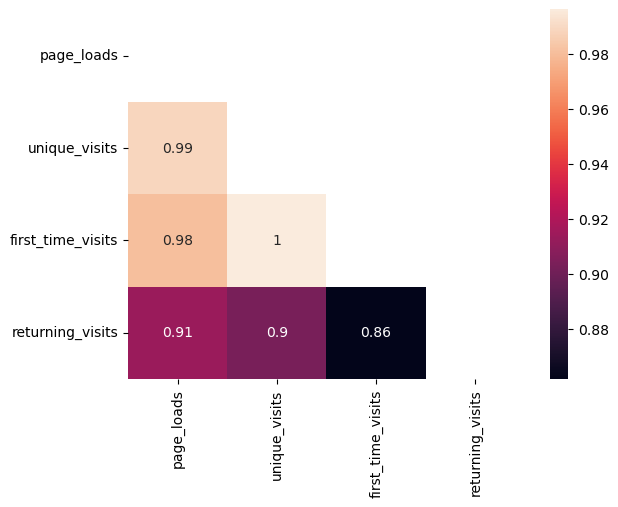

In [9]:
mask = np.triu(np.ones_like(df[series_cols].corr(), dtype=bool))
sns.heatmap(df[series_cols].corr(), annot=True, mask=mask)
plt.show()

Видим, что данные сильно похожи между собой! Зная один ряд, мы почти наверняка восстановим и другой ряд. 
Значит, не нужно думать о сложных методах, чтобы прогнозировать многомерные ряды.

А как выглядит исследуемый временной ряд?
Построим подневную кривую и попробуем "на глаз" оценить:

- среднее: если "мысленно" провести линию среднего, какая она - стабильная, растущая, убывающая?
- разброс: как бы вы описали характер разброса данных по этой картинке?
- есть ли какие-то паттерны?

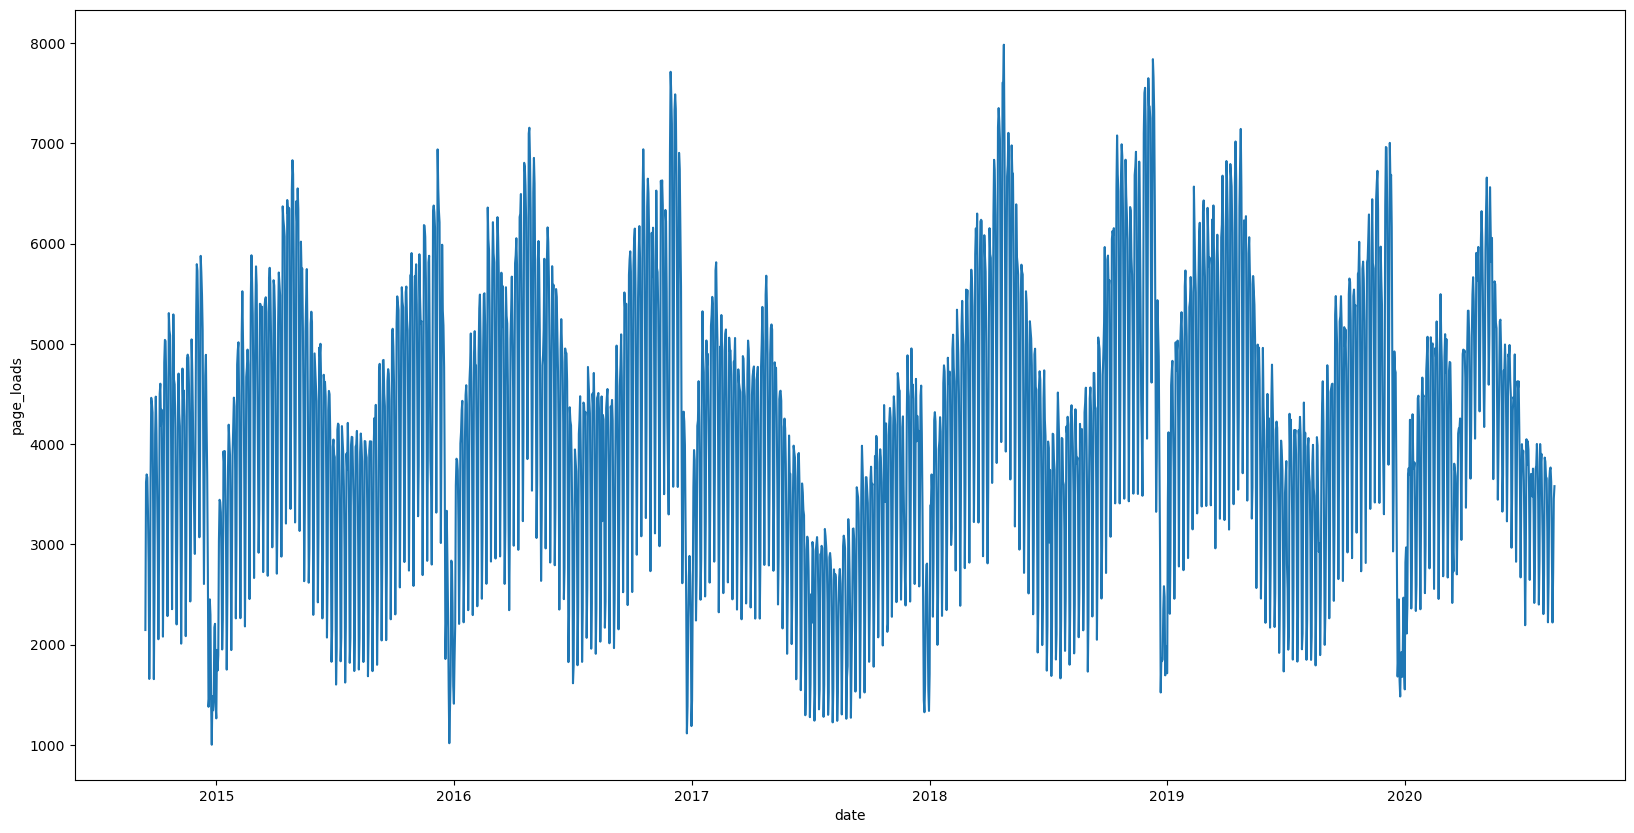

In [10]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='date', y='page_loads')
plt.show()

А если посмотреть на недельные данные? Месячные? Может быть, увидим интересное. Здесь и пригодится трансформация колонки даты - сделаем колонки, по которым сможем посчитать агрегации в нужных срезах.

In [11]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week 

Вопросы к обсуждению остаются те же. Но при этом данных сразу за год нет, их надо собрать самим. С точки зрения техники совершенно не важно, как агрегируем и за какой временной период - суммируем, считаем среднее или медиану за период - код один и тот же по структуре.


В следующих блоках делаем следующее:
- собираем статистику (сумма, среднее, медиана и т.п.) за нужный период (год, месяц, неделя)
- визуализируем кривую

### Годичная агрегация

Начнем с анализа по годам. Как изменялось количество загрузок год от года?

In [12]:
yearly_data = df.groupby('year')['page_loads'].mean().reset_index()
yearly_data

year   page_loads
0  2014  3649.926606
1  2015  4082.610959
2  2016  4421.527322
3  2017  3396.175342
4  2018  4500.495890
5  2019  4345.380822
6  2020  4090.168831

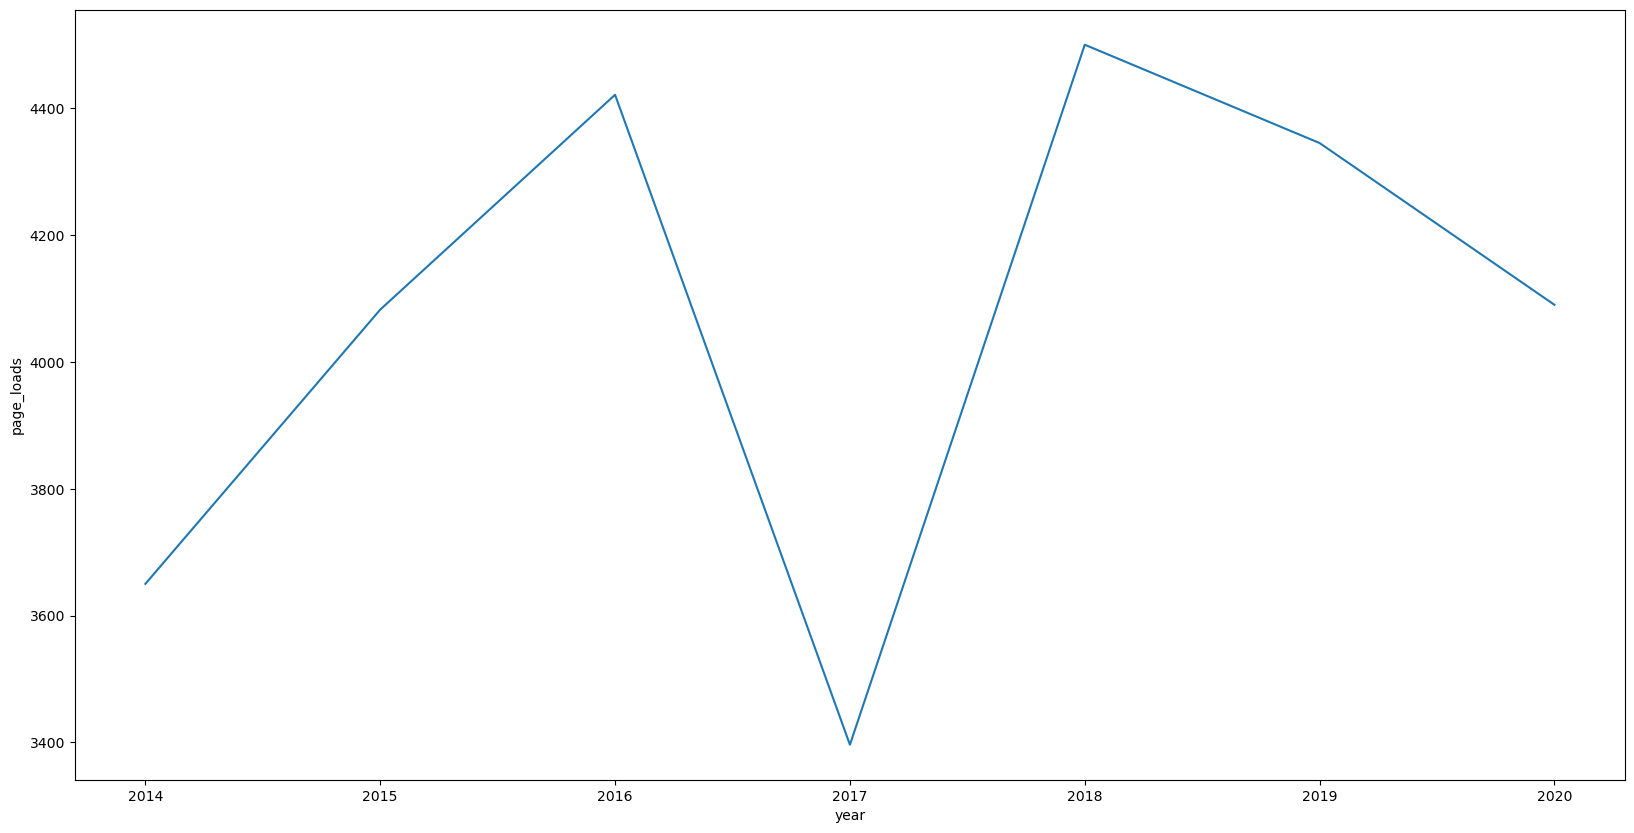

In [13]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=yearly_data, x='year', y='page_loads')
plt.show()

### Месячная агрегация

Теперь смотрим на ежемесячные данные. Обратите внимание, что данные за несколько лет. Агрегация только по месяцу смешает данные за разные годы, поэтому делаем агрегацию по году и месяцу

In [14]:
monthly_data = df.groupby(['year', 'month'])['page_loads'].mean().reset_index()
monthly_data['index'] = monthly_data['year'].astype(str) + '_' + monthly_data['month'].astype(str)
monthly_data

year  month   page_loads    index
0   2014      9  3297.176471   2014_9
1   2014     10  3934.935484  2014_10
2   2014     11  3806.333333  2014_11
3   2014     12  3407.000000  2014_12
4   2015      1  3099.258065   2015_1
..   ...    ...          ...      ...
67  2020      4  5048.066667   2020_4
68  2020      5  5032.935484   2020_5
69  2020      6  4156.100000   2020_6
70  2020      7  3431.838710   2020_7
71  2020      8  3207.055556   2020_8

[72 rows x 4 columns]

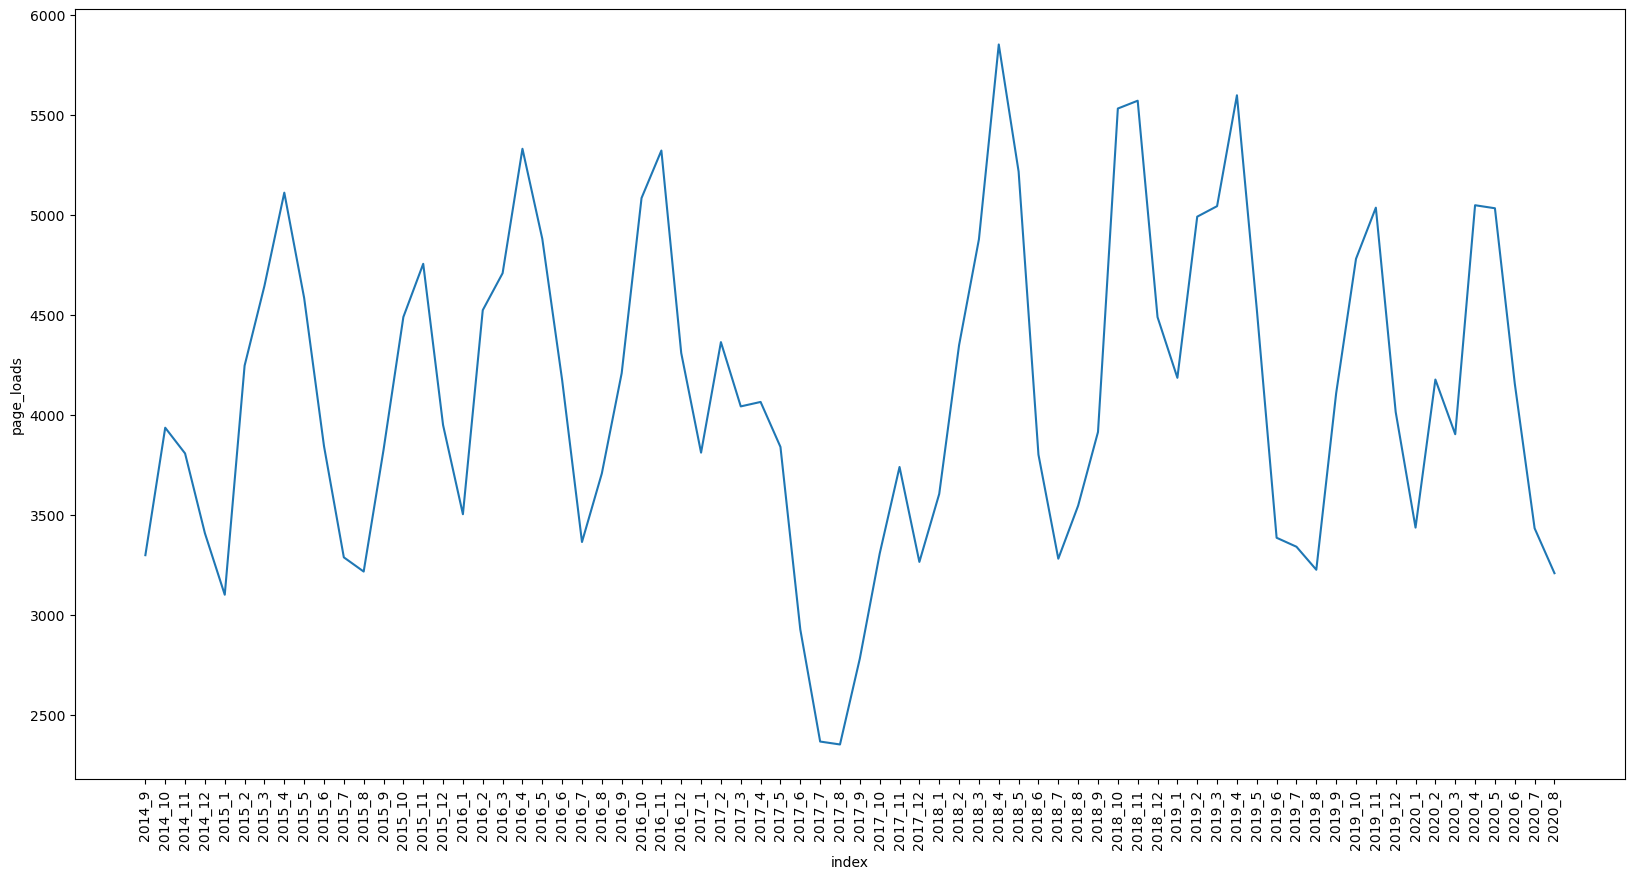

In [15]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=monthly_data, x='index', y='page_loads')
plt.xticks(rotation=90)
plt.show()

### Недельная агрегация

In [16]:
weekly_data = df.groupby(['year', 'week'])['page_loads'].mean().reset_index()
weekly_data['index'] = weekly_data['year'].astype(str) + '_' + weekly_data['week'].astype(str)
weekly_data

year  week   page_loads    index
0    2014     1  1920.666667   2014_1
1    2014    37  2146.000000  2014_37
2    2014    38  3009.000000  2014_38
3    2014    39  3467.571429  2014_39
4    2014    40  3444.857143  2014_40
..    ...   ...          ...      ...
308  2020    30  3432.142857  2020_30
309  2020    31  3300.285714  2020_31
310  2020    32  3286.714286  2020_32
311  2020    33  3240.285714  2020_33
312  2020    34  3518.500000  2020_34

[313 rows x 4 columns]

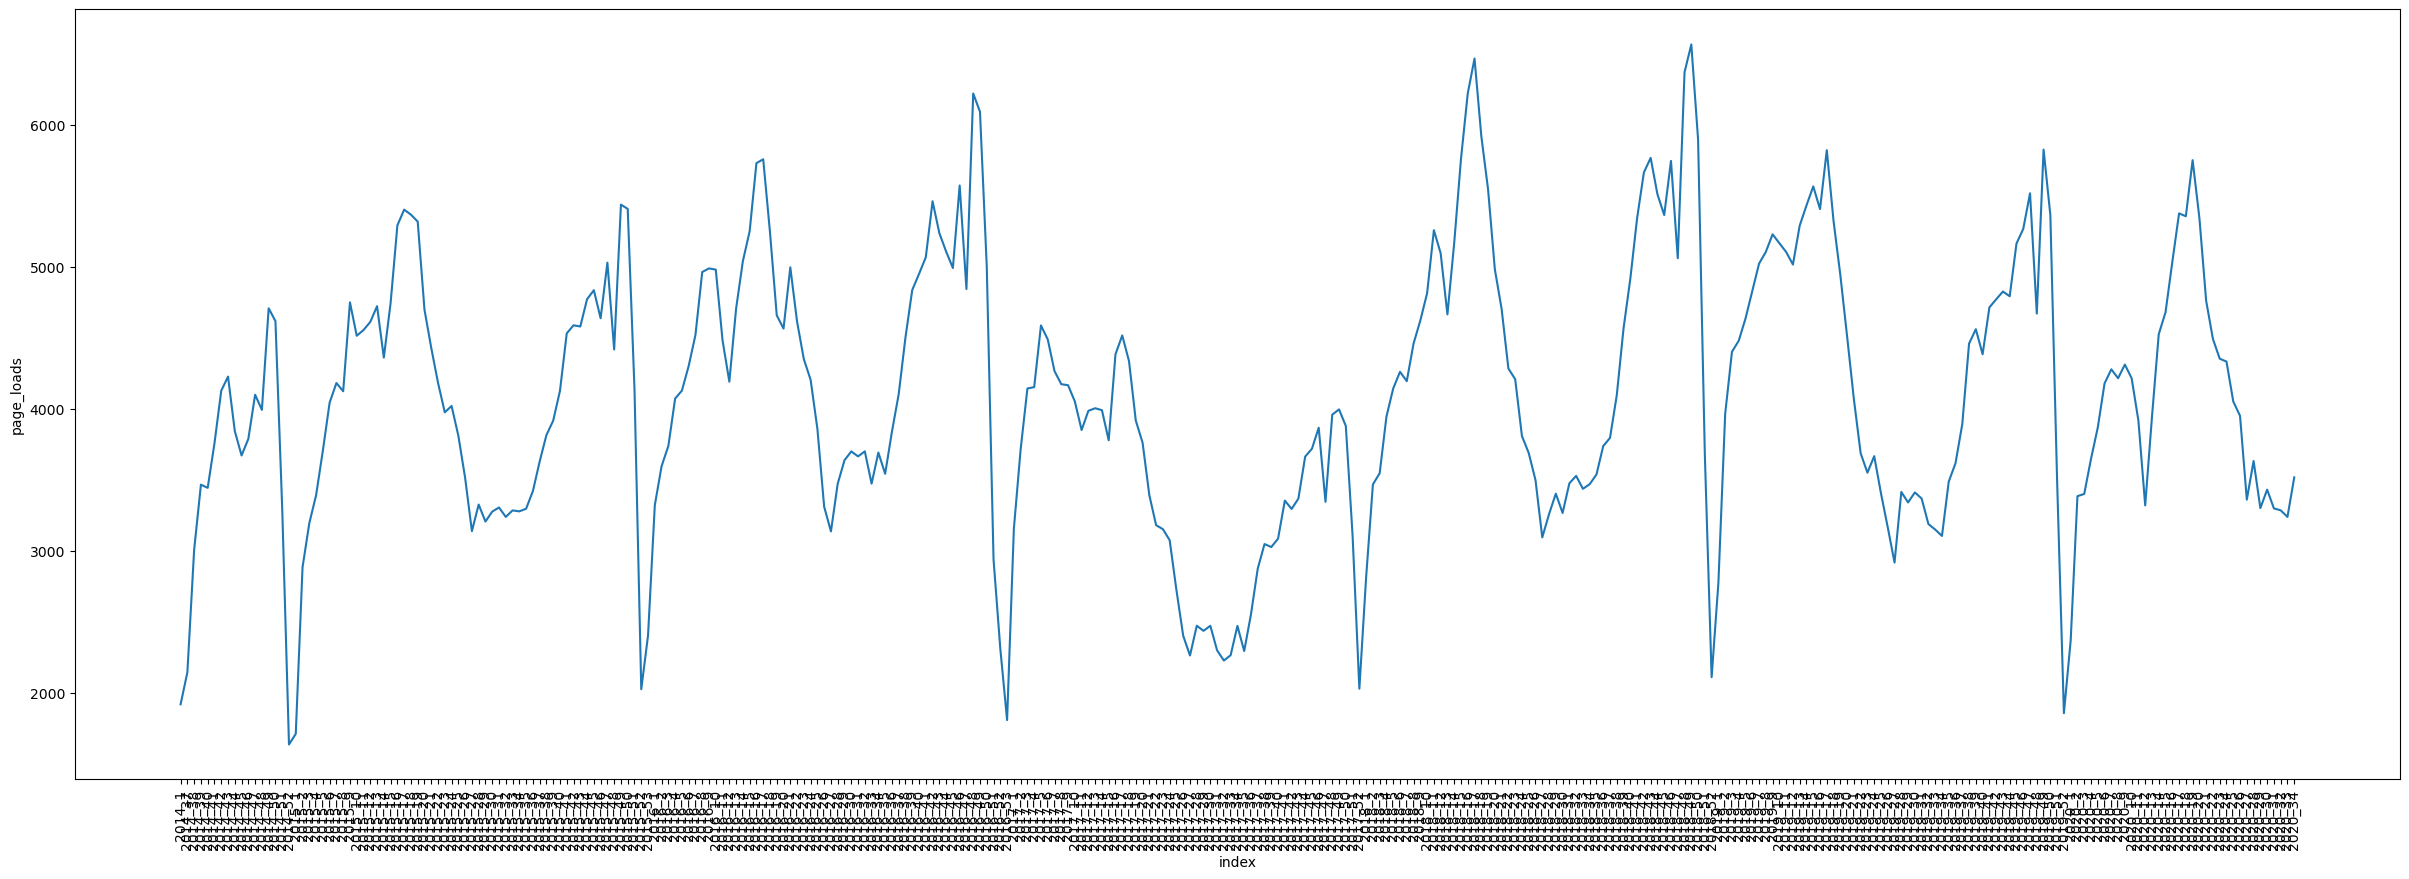

In [17]:
plt.figure(figsize=(30, 10))
sns.lineplot(data=weekly_data, x='index', y='page_loads')
plt.xticks(rotation=90)
plt.show()

### Поиск сезонности

<AxesSubplot:xlabel='day', ylabel='page_loads'>

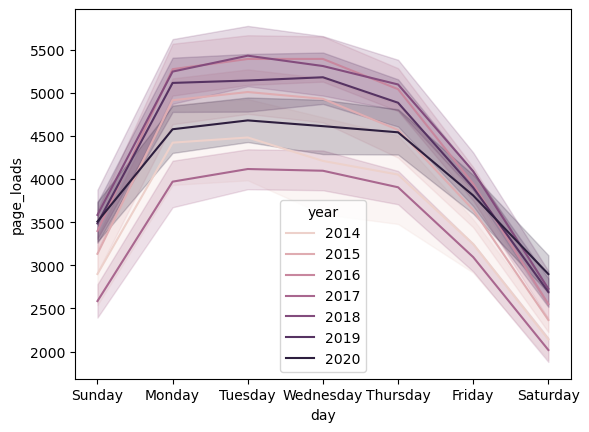

In [18]:
sns.lineplot(data=df, x='day', y='page_loads', hue='year')

<AxesSubplot:xlabel='month', ylabel='page_loads'>

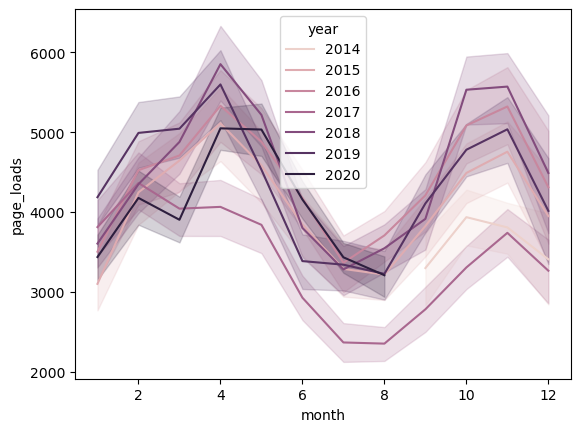

In [19]:
sns.lineplot(data=df, x='month', y='page_loads', hue='year')

### Скользящее среднее

<AxesSubplot:>

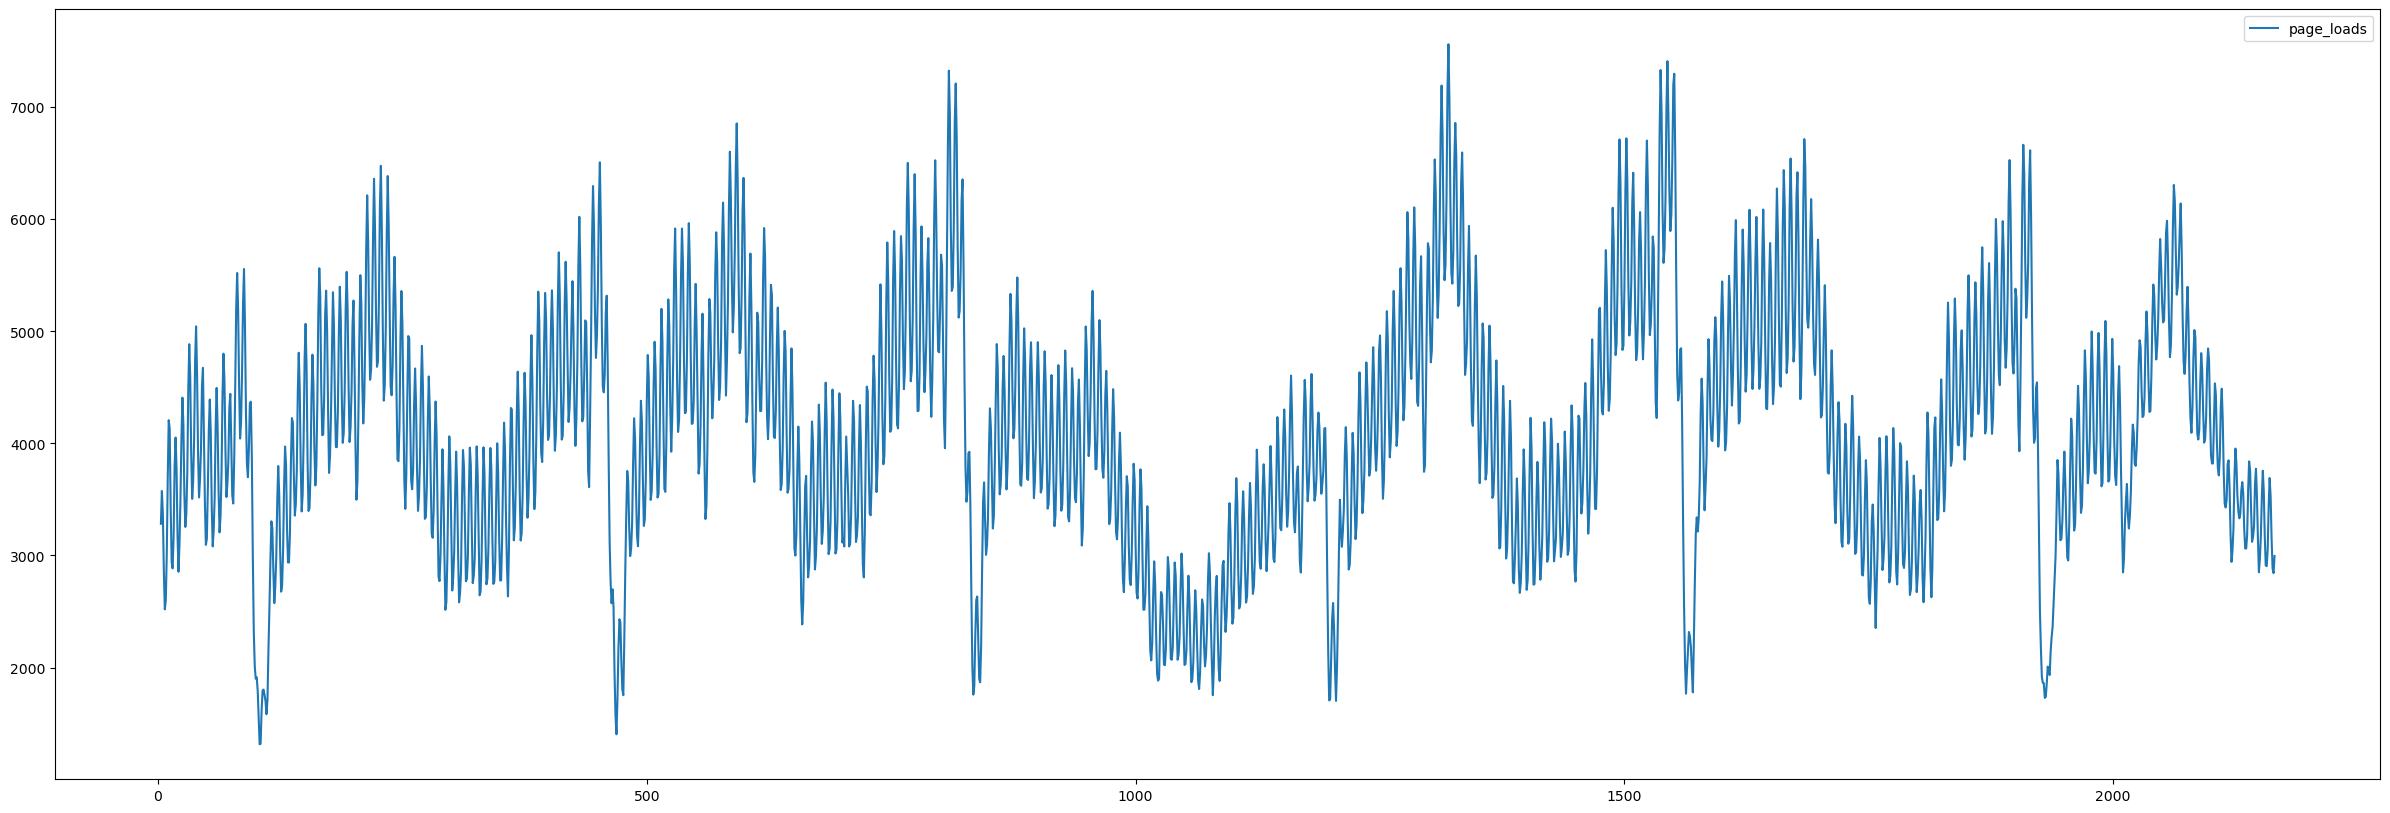

In [20]:
moving_avg = df.drop(['date', 'day'], axis=1).rolling(window = 4).mean()[['page_loads']]
plt.figure(figsize=(30, 10))
sns.lineplot(moving_avg)

<AxesSubplot:>

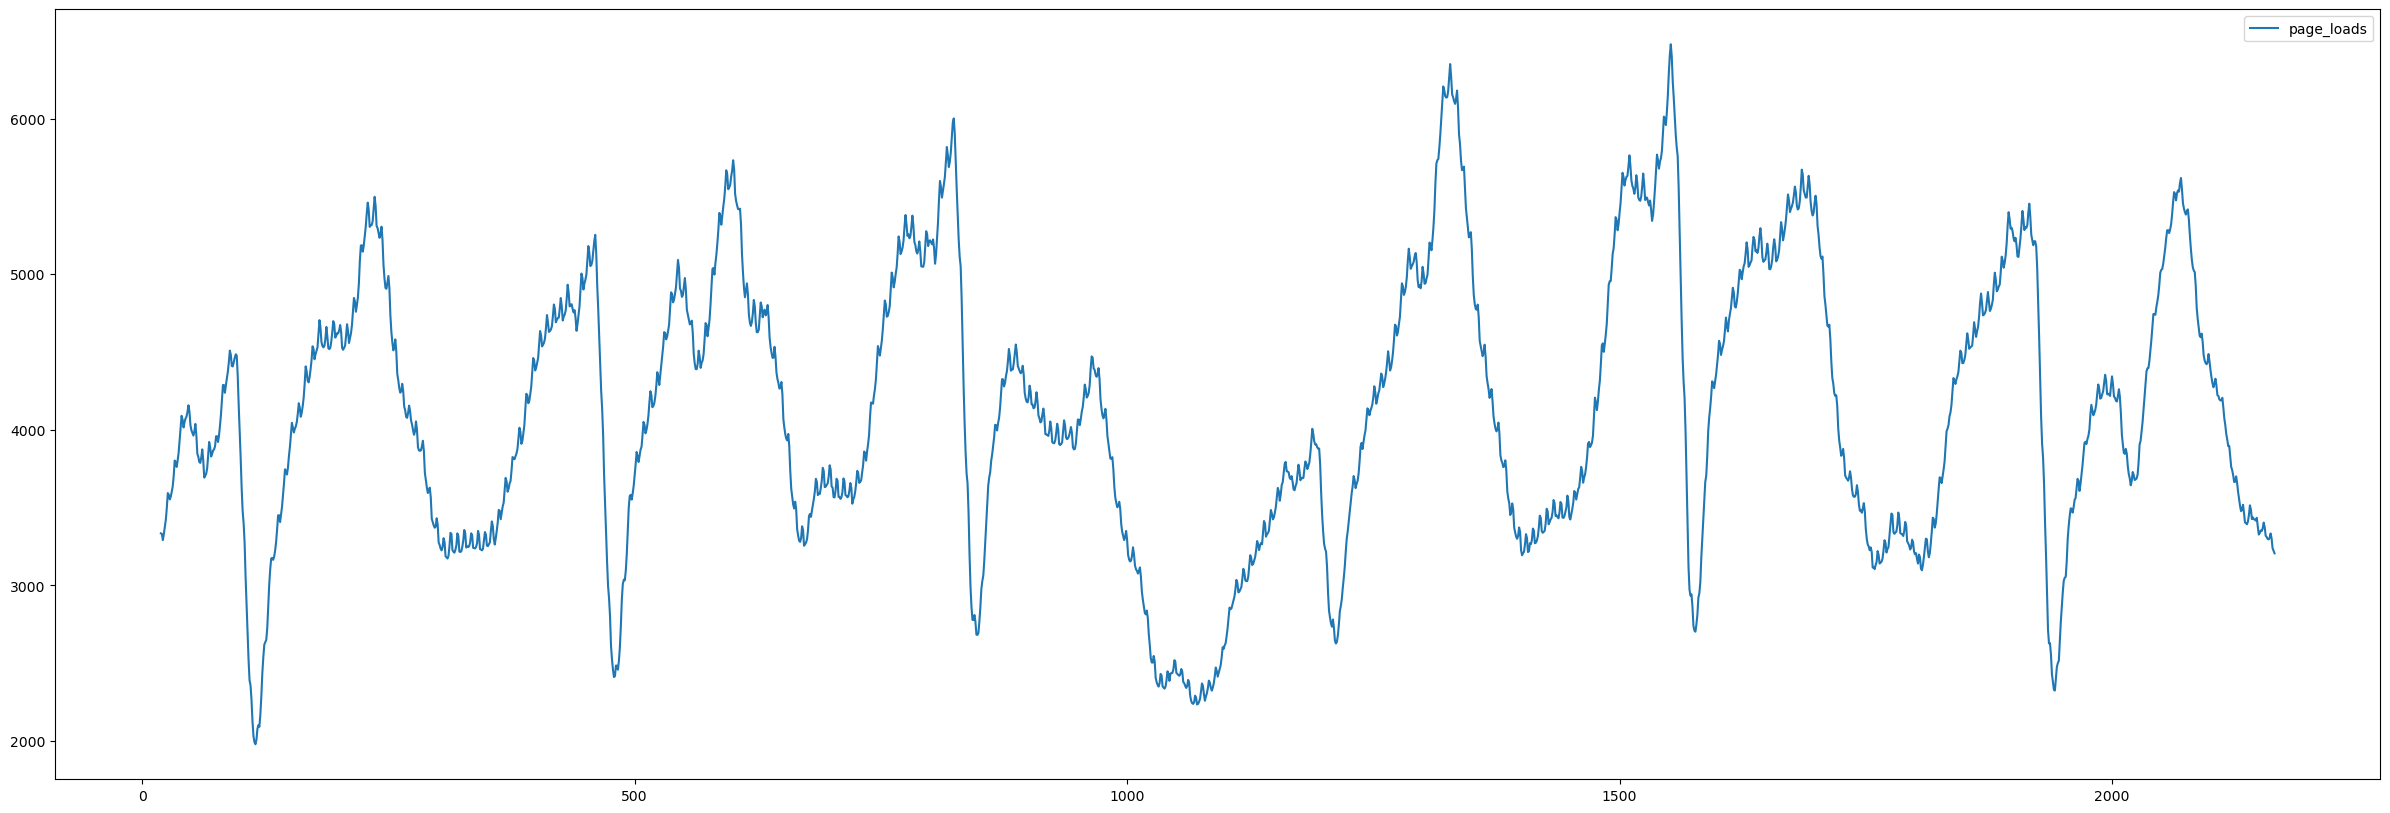

In [21]:
moving_avg = df.drop(['date', 'day'], axis=1).rolling(window = 20).mean()[['page_loads']]
plt.figure(figsize=(30, 10))
sns.lineplot(moving_avg)

<AxesSubplot:>

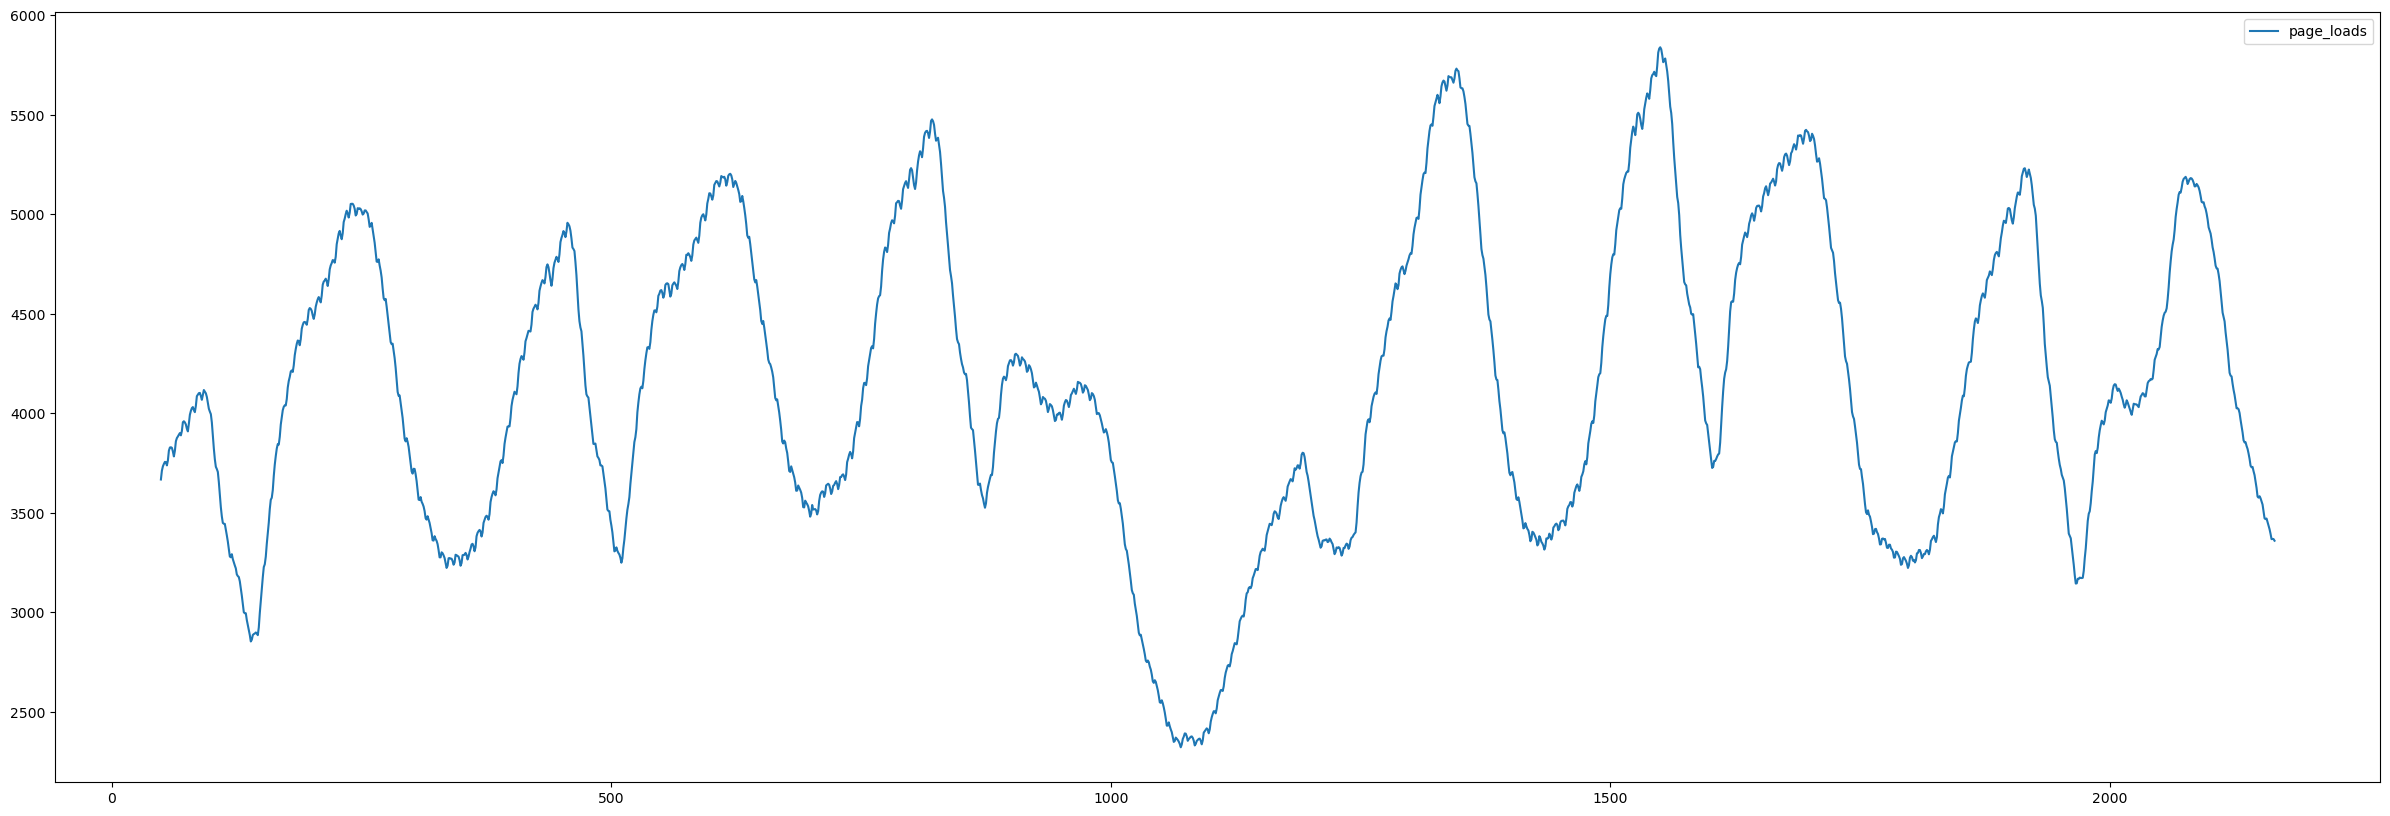

In [22]:
moving_avg = df.drop(['date', 'day'], axis=1).rolling(window = 50).mean()[['page_loads']]
plt.figure(figsize=(30, 10))
sns.lineplot(moving_avg)

## Анализ компонент

### Попробовать самим смоделировать тренд и сезонность

место для простого правила оценки тренда

место для простого правила оценки сезонности

место для расчета ошибок

визуализация

### Использование стандартных средств

In [23]:
tdi = pd.DatetimeIndex(df.date)
df.set_index(tdi, inplace=True)

Рассказ о том, как работает эта часть

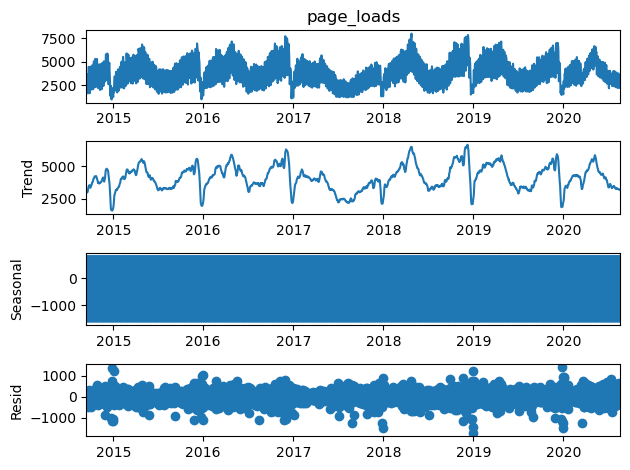

In [24]:
decompose = seasonal_decompose(x=df['page_loads'])
decompose.plot()

plt.show()

Покопаться со всеми в сезонности - как в таблице, так и отдельно порисовать,

## Моделирование

### Разбиение на train - test

In [25]:
df.index

DatetimeIndex(['2014-09-14', '2014-09-15', '2014-09-16', '2014-09-17',
               '2014-09-18', '2014-09-19', '2014-09-20', '2014-09-21',
               '2014-09-22', '2014-09-23',
               ...
               '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12',
               '2020-08-13', '2020-08-14', '2020-08-15', '2020-08-16',
               '2020-08-17', '2020-08-18'],
              dtype='datetime64[ns]', name='date', length=2166, freq=None)

In [26]:
division_date = '2020-08-01'

In [27]:
train_data = df[df.index < division_date]['page_loads']
test_data = df[df.index >= division_date]['page_loads']

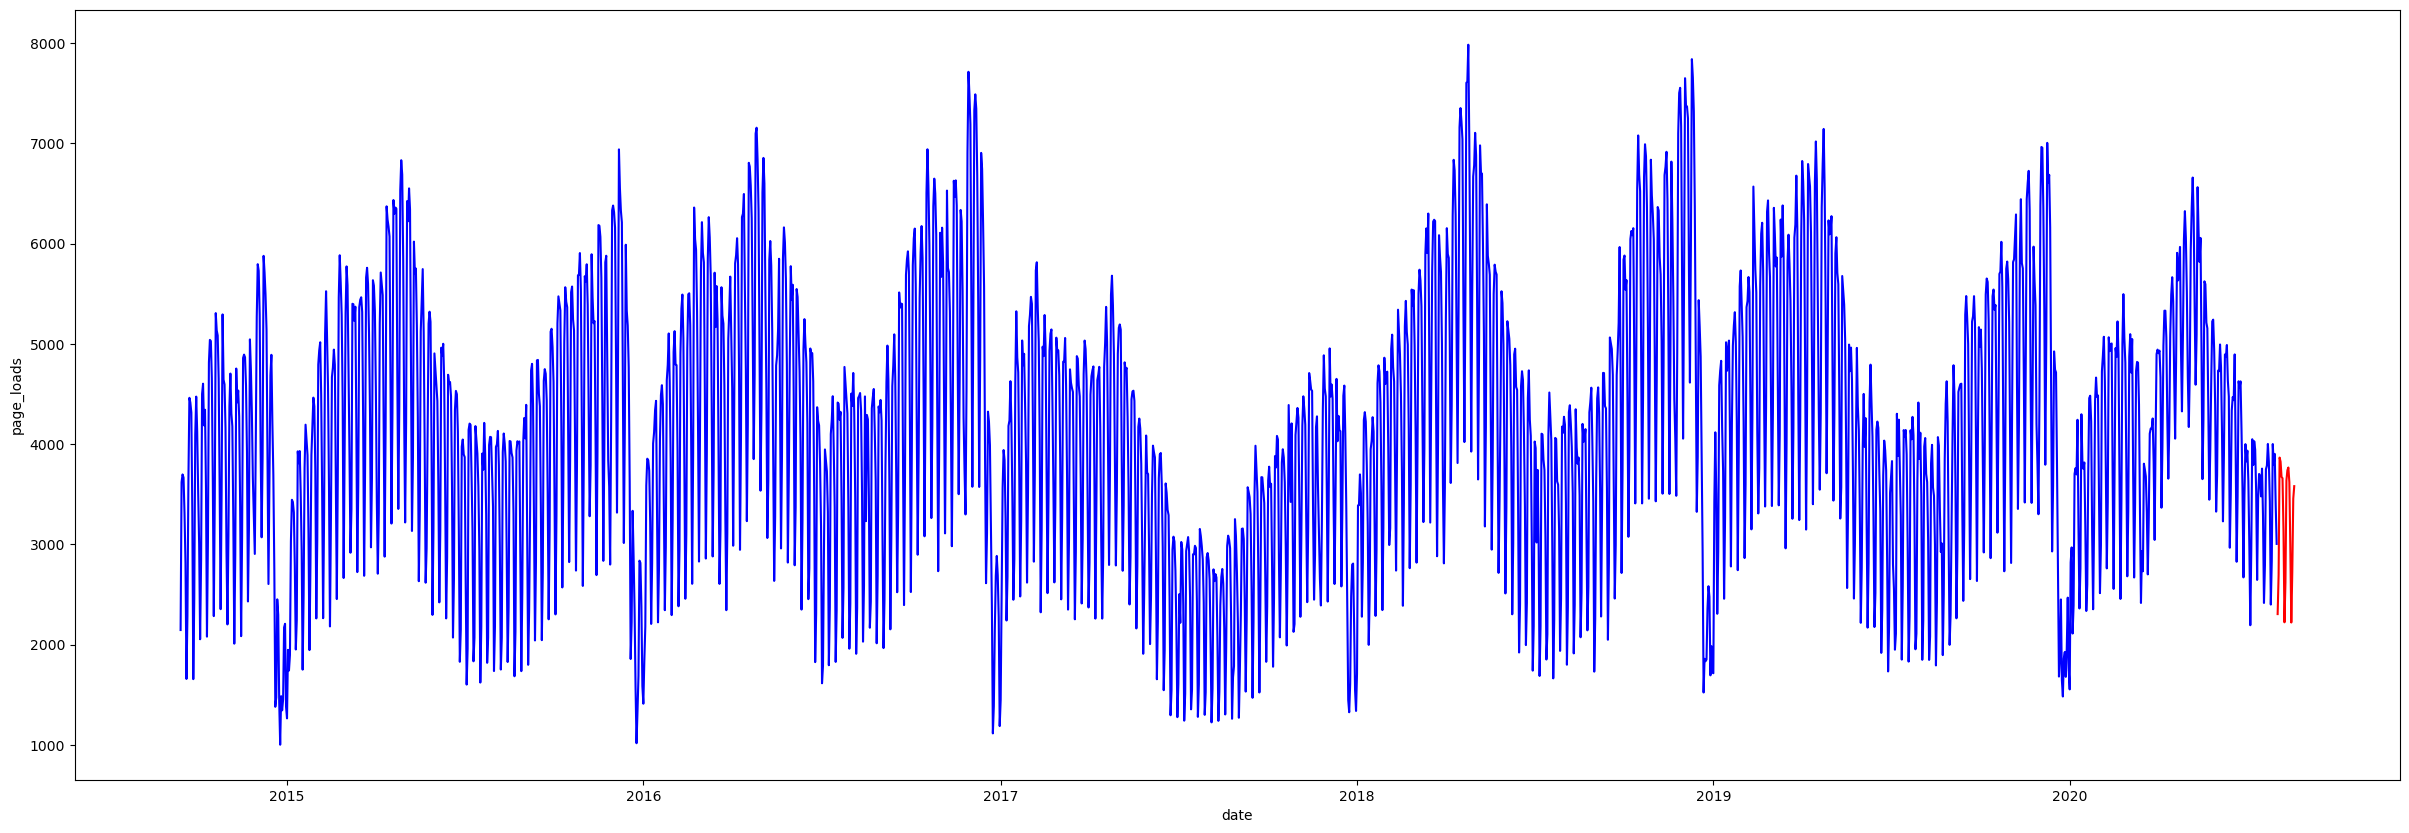

In [28]:
plt.figure(figsize=(30, 10))
sns.lineplot(train_data, color = "blue")
sns.lineplot(test_data, color = "red")
plt.show()

In [29]:
len(test_data)

18

### Наивный прогноз_1

In [30]:
mean_value = train_data.mean()

In [31]:
naive_preds = [mean_value]*len(test_data)

In [32]:
naive_preds = pd.Series(naive_preds, index=test_data.index)

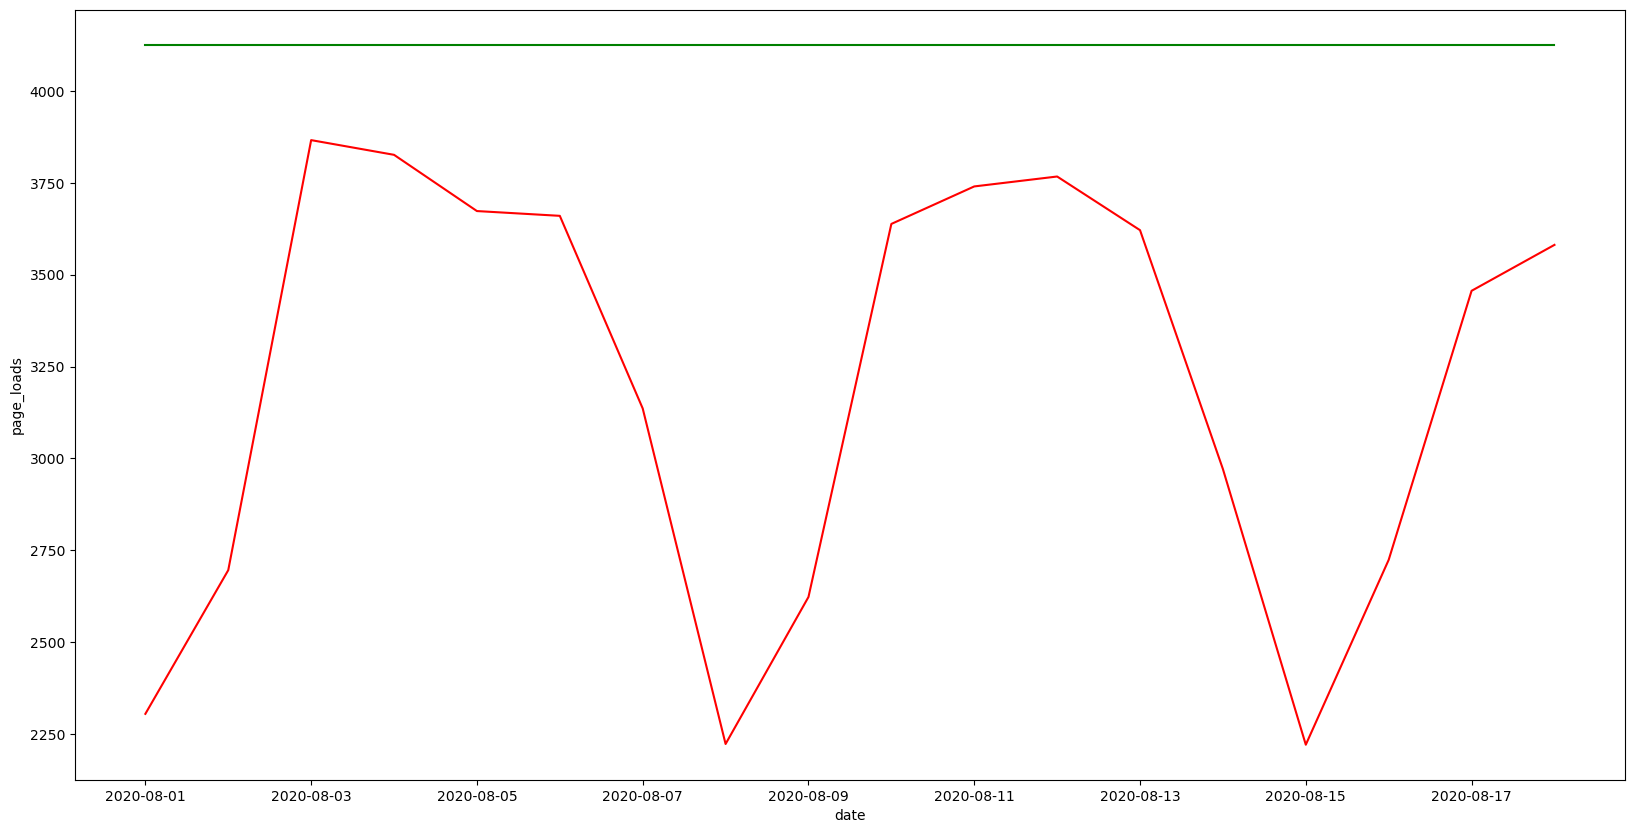

In [33]:
plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red")
sns.lineplot(naive_preds, color = "green")

plt.show()

In [34]:
print('MAE прогноза:', mae(test_data, naive_preds))
print('R2 модели:', r2_score(test_data, naive_preds))

MAE прогноза: 918.5147423960271
R2 модели: -2.5114235200703456


### Наивный прогноз_2

$y_{t+1} = y_{t}$

In [35]:
naive_preds_2 = [train_data[-1]]
for i in range(1, len(test_data)):
    naive_preds_2.append(naive_preds_2[i-1])

In [36]:
naive_preds_2 = pd.Series(naive_preds_2, index=test_data.index)

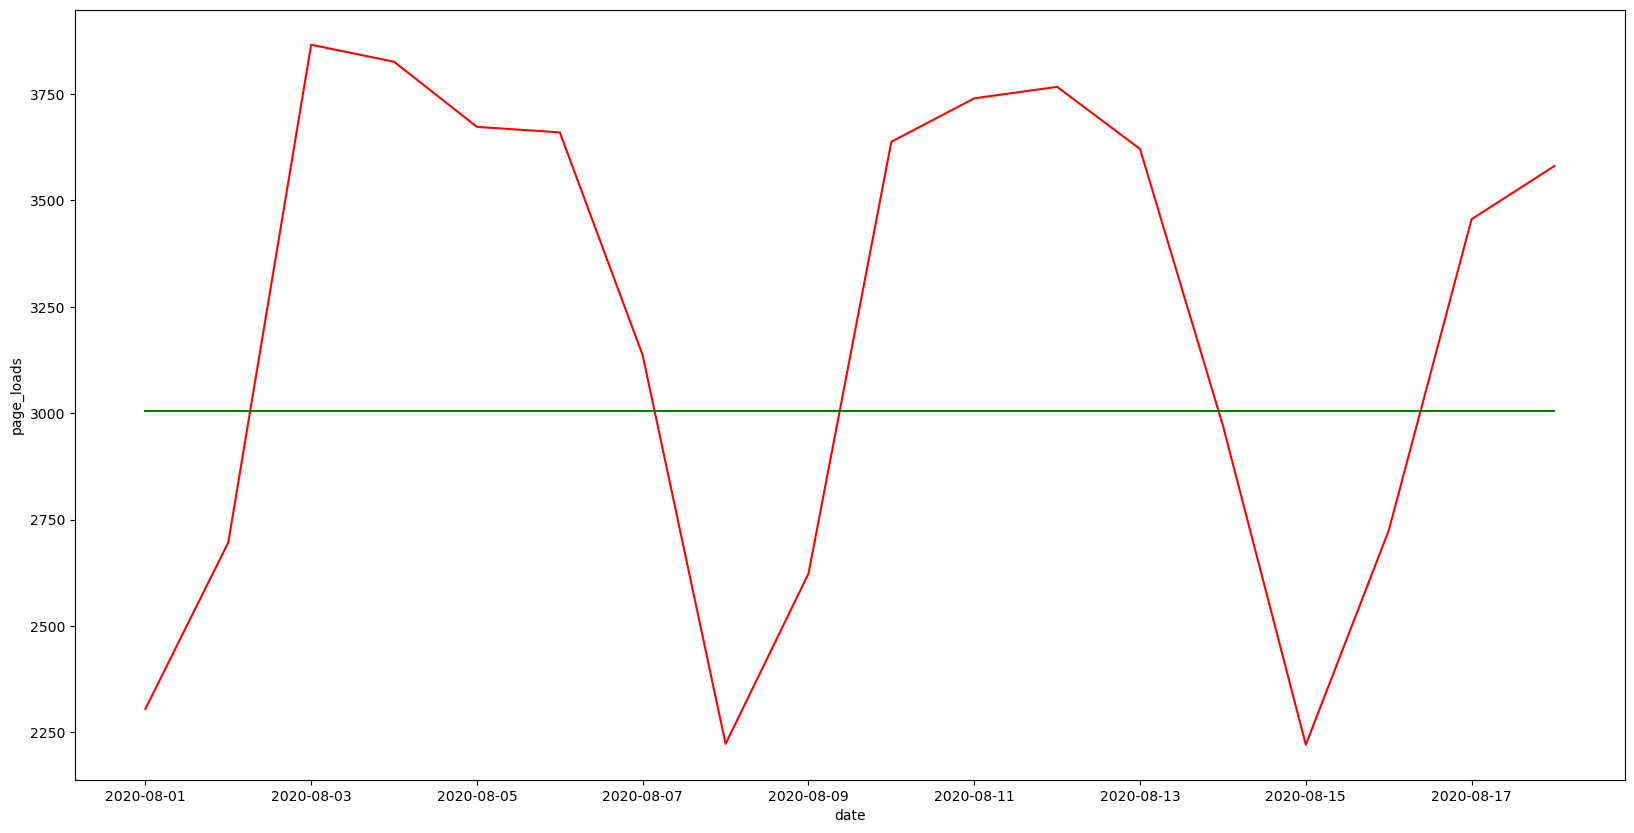

In [37]:
plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red")
sns.lineplot(naive_preds_2, color = "green")

plt.show()

In [38]:
print('MAE прогноза:', mae(test_data, naive_preds_2))
print('R2 модели:', r2_score(test_data, naive_preds_2))

MAE прогноза: 565.6111111111111
R2 модели: -0.12153161989070749


Мораль: простое не поможет!

## Экспоненциальное сглаживание

В модели экспоненциального сглаживания (exponential smoothing) или экспоненциального скользящего среднего берем все предыдущие значения и задаем каждому из наблюдений определенный вес и (экспоненциально) уменьшаем этот вес по мере углубления в прошлое.

$$\hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat{y}_{t}$$

In [39]:
train_data

date
2014-09-14    2146
2014-09-15    3621
2014-09-16    3698
2014-09-17    3667
2014-09-18    3316
              ... 
2020-07-27    4001
2020-07-28    3795
2020-07-29    3903
2020-07-30    3397
2020-07-31    3005
Name: page_loads, Length: 2148, dtype: int64

In [40]:
alpha = 0.6
 
# первое значение совпадает со значением временного ряда
exp_smoothing = [train_data[0]]
 
# в цикле for последовательно применяем формулу ко всем элементам ряда
for i in range(1, len(train_data)):
                 exp_smoothing.append(alpha *train_data[i] + (1 - alpha) * exp_smoothing[i - 1])


In [41]:
exp_smoothing = pd.Series(exp_smoothing)
exp_smoothing.index = train_data.index

<AxesSubplot:xlabel='date', ylabel='page_loads'>

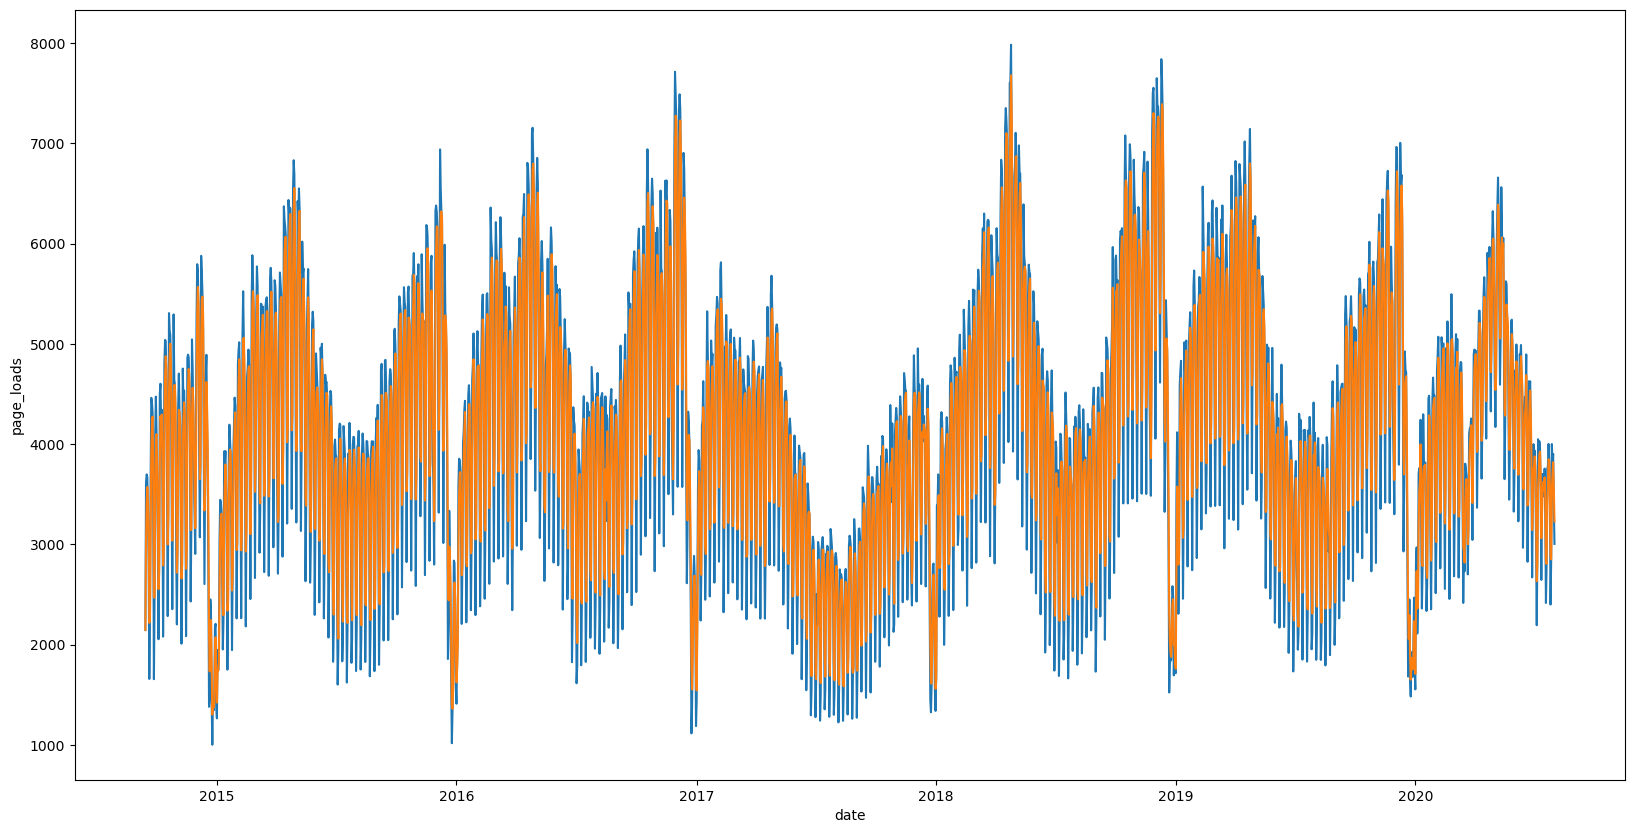

In [42]:
plt.figure(figsize=(20, 10))
sns.lineplot(train_data);
sns.lineplot(exp_smoothing)

In [43]:
exp_smoothing[-2:]

date
2020-07-30    3565.880032
2020-07-31    3229.352013
dtype: float64

Акцент: прогнозирует  на шаг вперед

А что, если нужно на больше?

### Prophet

In [44]:
from prophet import Prophet

In [45]:
train_data.head()

date
2014-09-14    2146
2014-09-15    3621
2014-09-16    3698
2014-09-17    3667
2014-09-18    3316
Name: page_loads, dtype: int64

In [46]:
train_data_prophet = train_data.reset_index().rename(columns={'date': 'ds', 'page_loads': 'y'})

In [47]:
model_prophet = Prophet()

In [48]:
model_prophet.fit(train_data_prophet)

00:03:55 - cmdstanpy - INFO - Chain [1] start processing
00:03:56 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
prophet_future = model_prophet.make_future_dataframe(periods=len(test_data))
prophet_future.tail()

ds
2161 2020-08-14
2162 2020-08-15
2163 2020-08-16
2164 2020-08-17
2165 2020-08-18

In [50]:
prophet_preds = model_prophet.predict(prophet_future)

Описать, что выдает

In [51]:
#[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
prophet_preds.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2014-09-14  3371.898688  1445.567538  2684.679912  3371.898688  3371.898688   
1 2014-09-15  3374.830791  3154.052436  4319.992142  3374.830791  3374.830791   
2 2014-09-16  3377.762893  3251.591781  4515.118873  3377.762893  3377.762893   
3 2014-09-17  3380.694996  3270.075564  4510.862561  3380.694996  3380.694996   
4 2014-09-18  3383.627098  3083.251318  4306.489357  3383.627098  3383.627098   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0    -1276.932169          -1276.932169          -1276.932169 -871.452402   
1      376.019847            376.019847            376.019847  733.197400   
2      533.714408            533.714408            533.714408  843.154774   
3      523.537400            523.537400            523.537400  786.346555   
4      315.615562            315.615562            315.615562  533.405292   

   weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
0   -871.452402   -871.452402 -405.479767   -405.479767   -405.479767   
1    733.197400    733.197400 -357.177554   -357.177554   -357.177554   
2    843.154774    843.154774 -309.440366   -309.440366   -309.440366   
3    786.346555    786.346555 -262.809155   -262.809155   -262.809155   
4    533.405292    533.405292 -217.789730   -217.789730   -217.789730   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  2094.966519  
1                         0.0  3750.850637  
2                         0.0  3911.477301  
3                         0.0  3904.232396  
4                         0.0  3699.242660

Считаем метрики

In [52]:
prophet_preds_value = prophet_preds[prophet_preds['ds'] >=division_date]['yhat']

In [53]:
print('MAE прогноза:', mae(test_data, prophet_preds_value))
print('R2 модели:', r2_score(test_data, prophet_preds_value))

MAE прогноза: 335.9560756980449
R2 модели: 0.5366101095104281


Рисуем смертные графики!

In [54]:
prophet_preds_value.index = test_data.index

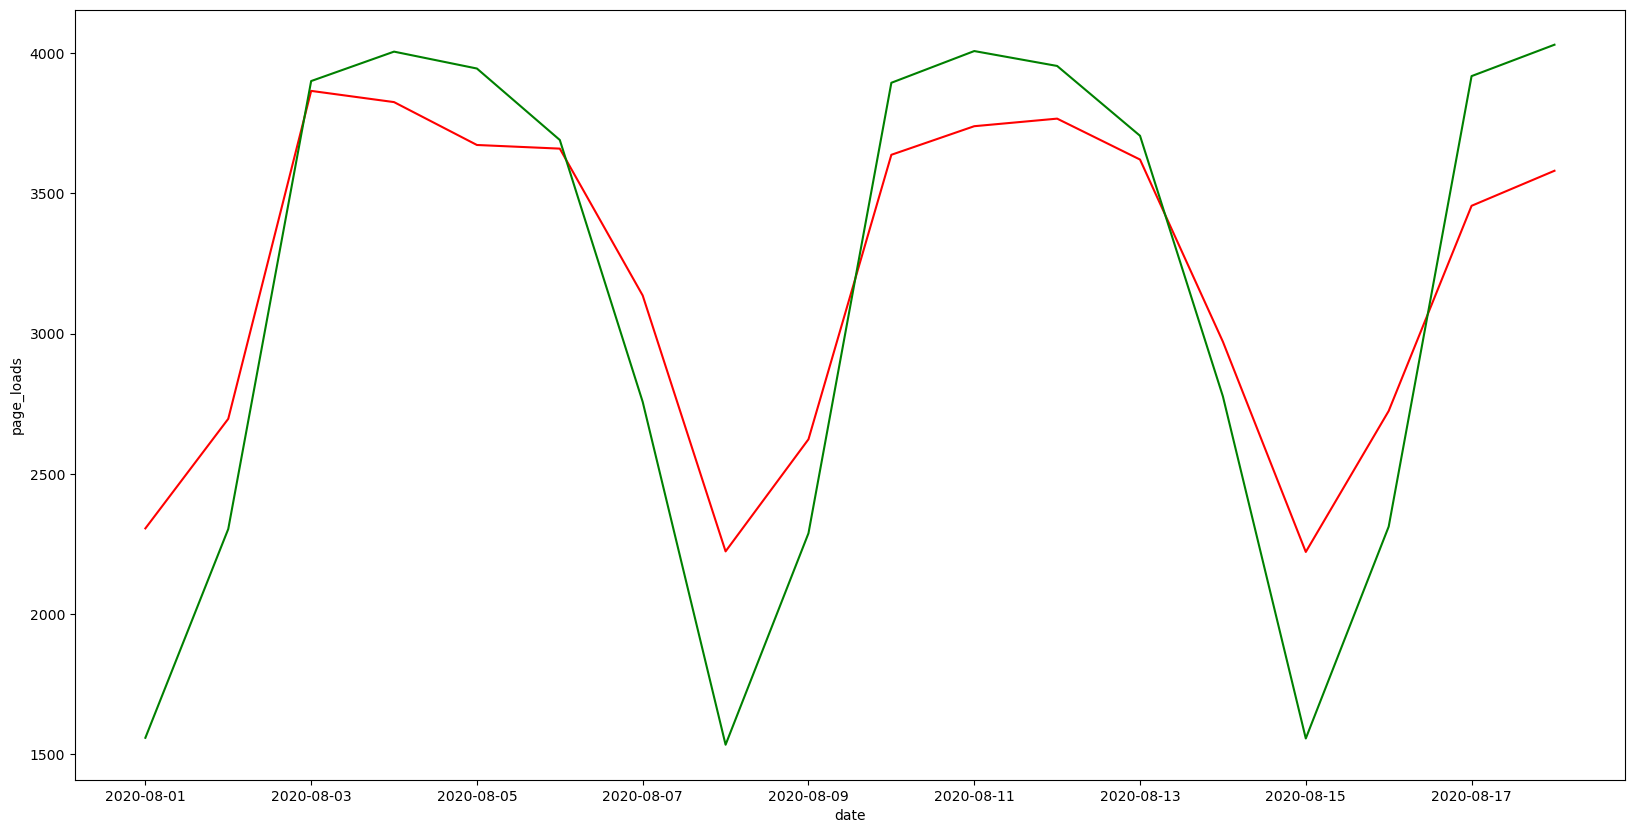

In [55]:
plt.figure(figsize=(20, 10))
sns.lineplot(test_data, color = "red")
sns.lineplot(pd.Series(prophet_preds_value), color = "green")

plt.show()

смотрим на креатив самой либы

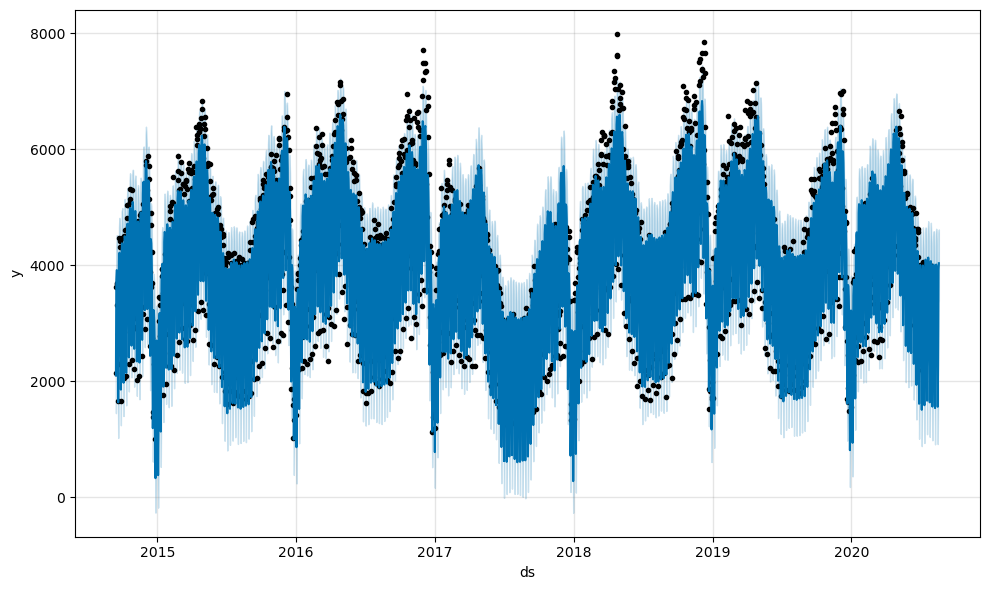

In [56]:
fig1 = model_prophet.plot(prophet_preds)


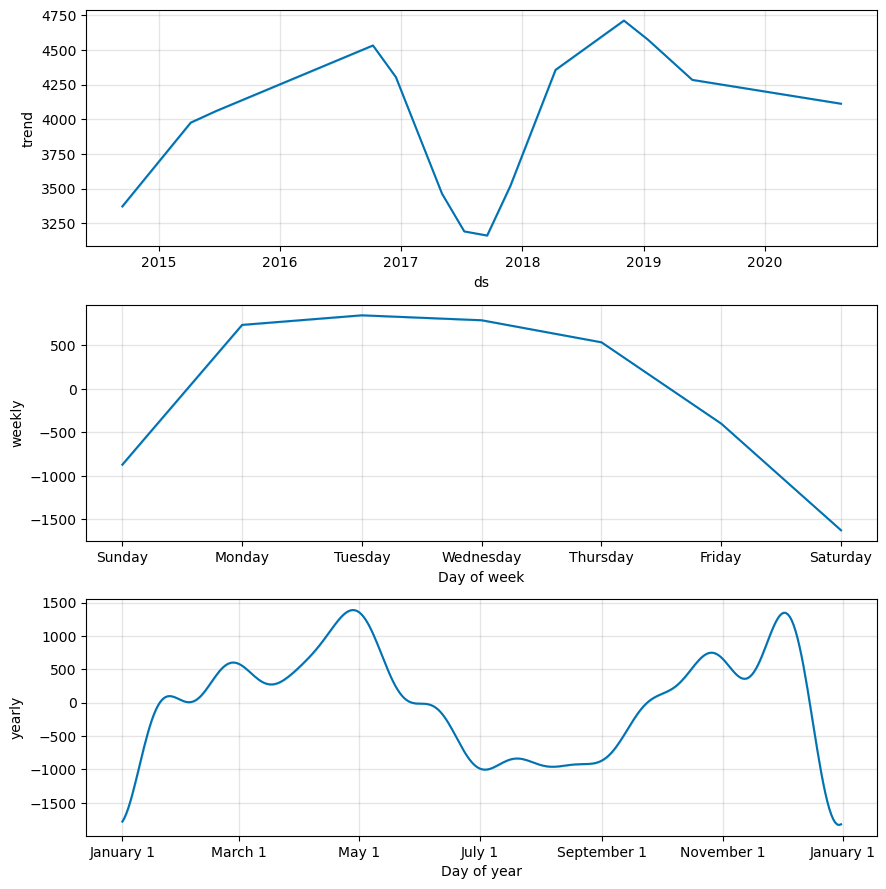

In [57]:
fig1 = model_prophet.plot_components(prophet_preds)


In [58]:
from prophet.plot import plot_plotly, plot_components_plotly

In [59]:
plot_plotly(model_prophet, prophet_preds)


# Бонус: Сложные валидации

# Бонус: Сравнение с ML-моделями

# Бонус: Проверка на стационарность

# Бонус: SARIMA